## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from kneed import KneeLocator

import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf, plot_accf_grid
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

# Load custom packages
%load_ext autoreload
%autoreload 2

from tsa_psf import visualize_psfs, compare_psfs

## Load data: Short Exposure PSFs

In [2]:
# Load short exposure PSFs
data_dir = "data/"

psfs_vega_1ms_bin1 = np.load(data_dir + 'PSFs_Vega_1ms_bin1.npy')  # High resolution, 100 observations
psfs_vega_1ms_bin2 = np.load(data_dir + 'PSFs_Vega_1ms_bin2.npy')  # Low resolution, 500 observations

print('Dimensions - bin1:', psfs_vega_1ms_bin1.shape)
print('Dimensions - bin2:', psfs_vega_1ms_bin2.shape)

Dimensions - bin1: (100, 99, 99)
Dimensions - bin2: (500, 99, 99)


### Visualize bin1 PSFs (higher resolution)

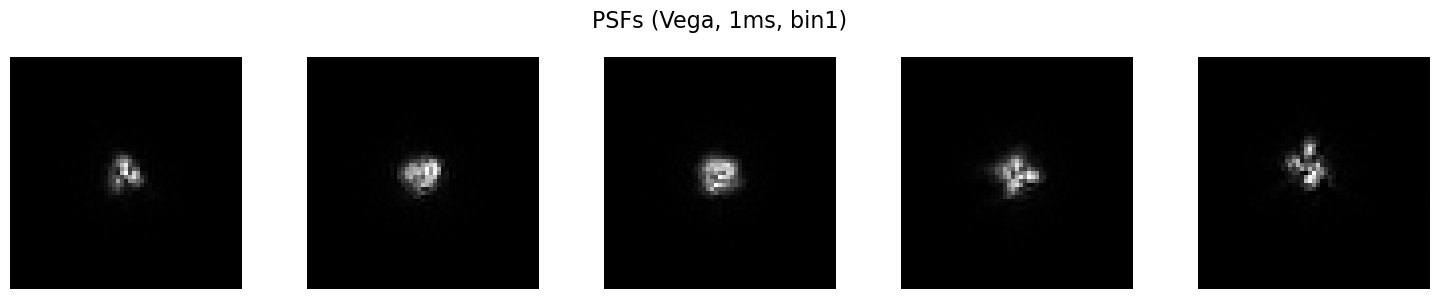

In [3]:
num_psfs_disp = 5  # Number of PSFs for display
ps1 = 20           # Cropping parameter

fig, axes = plt.subplots(1, num_psfs_disp, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(psfs_vega_1ms_bin1[i,ps1:-ps1,ps1:-ps1], cmap='gray', origin='lower', interpolation='none')
    ax.axis('off')
fig.suptitle("PSFs (Vega, 1ms, bin1)", fontsize=16)
plt.tight_layout()
plt.show()

### Visualize bin2 PSFs (lower resolution)

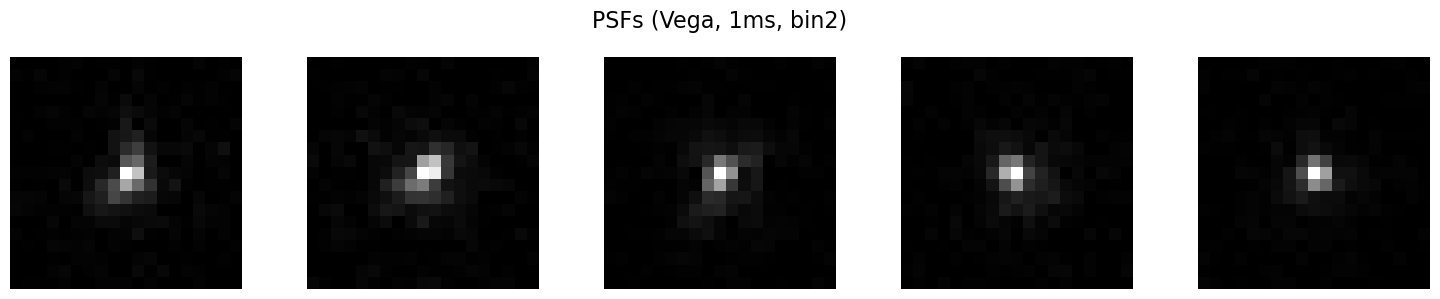

In [4]:
num_psfs_disp = 5  # Number of PSFs for display
ps2 = 40           # Cropping parameter

fig, axes = plt.subplots(1, num_psfs_disp, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(psfs_vega_1ms_bin2[i,ps2:-ps2,ps2:-ps2], cmap='gray', origin='lower', interpolation='none')
    ax.axis('off')
fig.suptitle("PSFs (Vega, 1ms, bin2)", fontsize=16)
plt.tight_layout()
plt.show()

### Visualize all PSFs

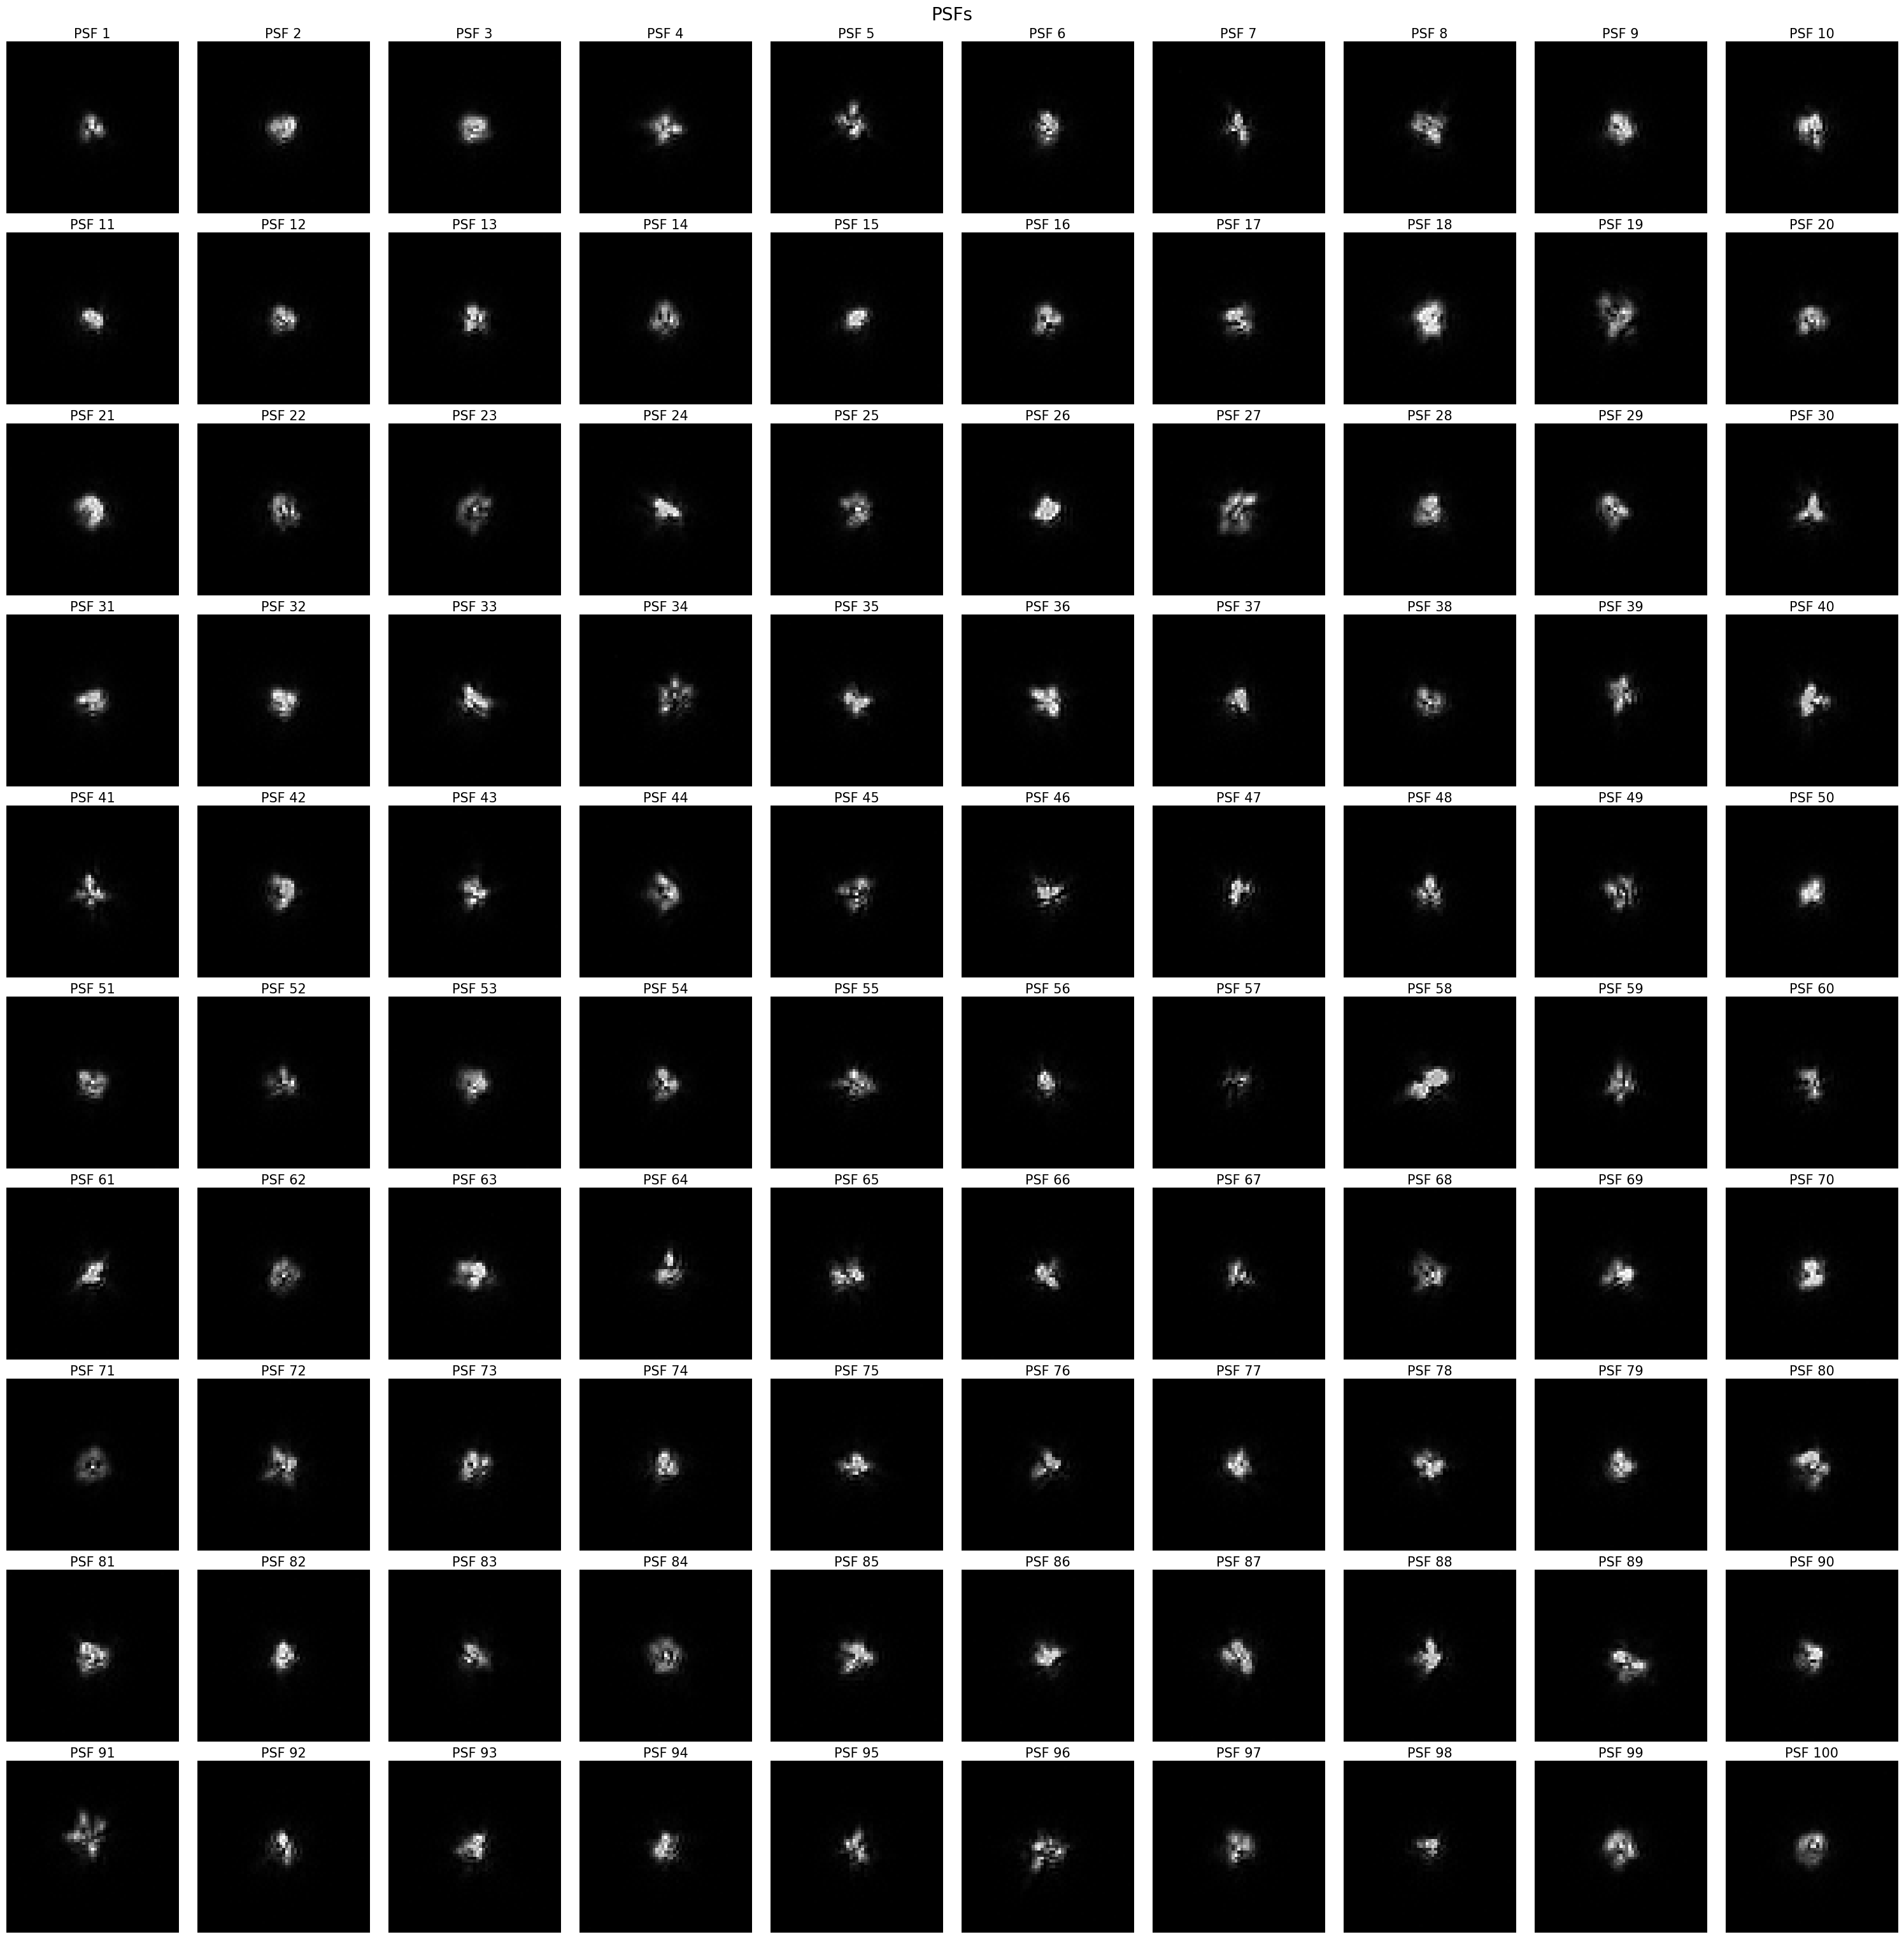

In [5]:
psfs = psfs_vega_1ms_bin1  # Chosen PSFs
num_psfs = psfs.shape[0]   # Number of PSFs
psf_size = psfs.shape[1]   # Length and width of PSFs
ps = ps1                   # Cropping parameter

fig_psfs, axes_psfs = visualize_psfs(psfs, ncols=10, title='PSFs', ps=ps)

## Perform PCA with the PSFs

In [6]:
# Flatten PSFs into column vectors
psfs_flattened = psfs.reshape(num_psfs, -1)

print('Dimensions of Flattened PSFs:', psfs_flattened.shape, '\n')

# Perform PCA on flattened PSFs
psf_pca = PCA()
psf_pca.fit(psfs_flattened)

Dimensions of Flattened PSFs: (100, 9801) 



PCA()

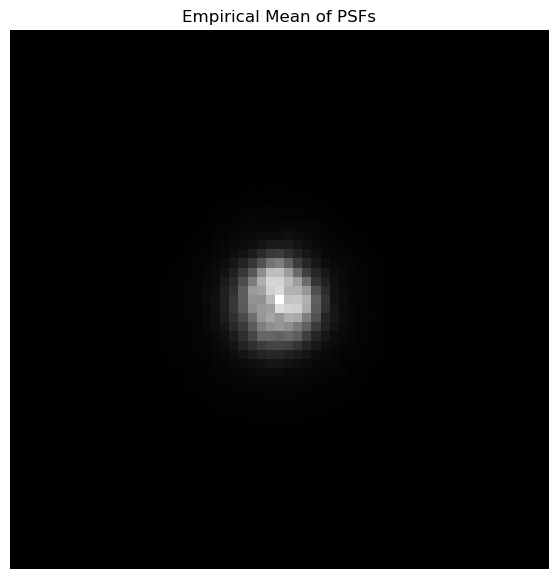

In [7]:
# Visualize empirical mean of PSFs
psf_mean = psf_pca.mean_.reshape(psf_size,psf_size)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(psf_mean[ps:-ps,ps:-ps], cmap='gray', origin='lower', interpolation='none')
ax.axis('off')
plt.title("Empirical Mean of PSFs")
plt.show()

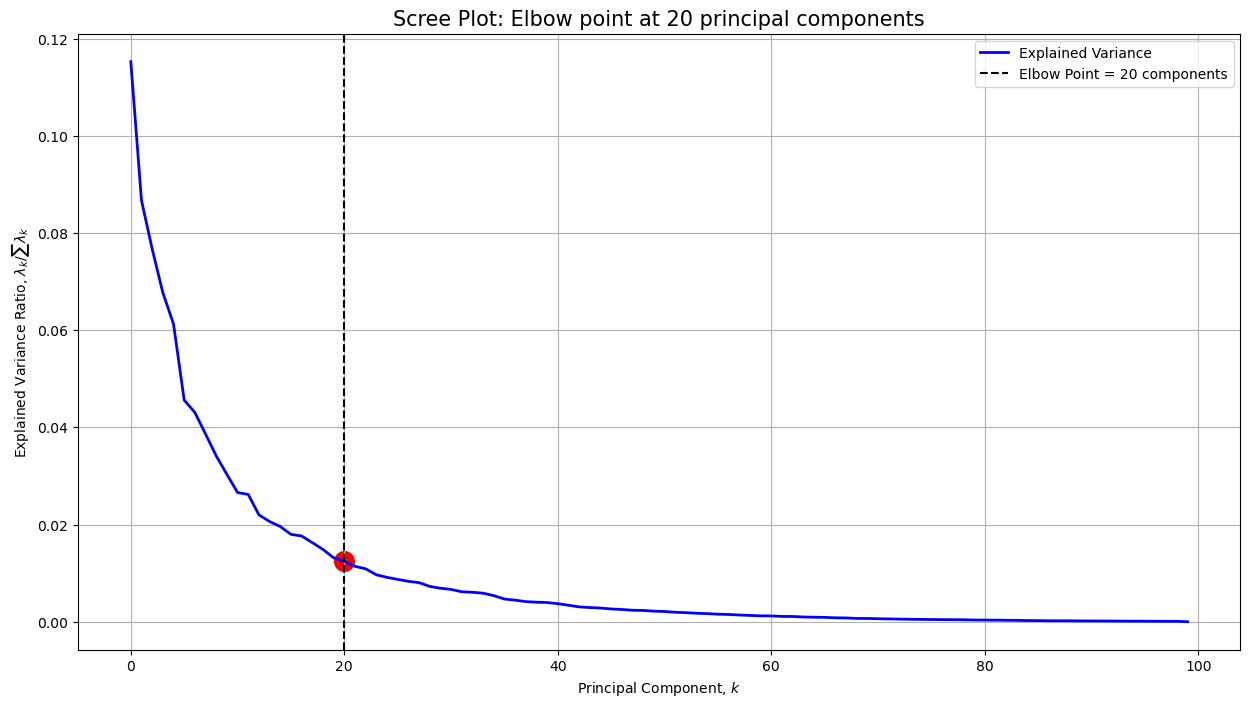

In [8]:
# Use Elbow method to identify number of principal components to retain
kneedle = KneeLocator(x=range(1, len(psf_pca.explained_variance_ratio_) + 1),
                      y=psf_pca.explained_variance_ratio_,
                      S=1.0,  # Sensitivity parameter
                      curve="convex",
                      direction="decreasing")

# Identify elbow point
elbow_point = kneedle.elbow

# Scree plot
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(psf_pca.explained_variance_ratio_, 'b', linewidth=2, label='Explained Variance')
ax.scatter(elbow_point, psf_pca.explained_variance_ratio_[elbow_point], c='r', s=200)
ax.axvline(x=elbow_point, color='k', linestyle='--', label='Elbow Point = {} components'.format(elbow_point))
ax.set_xlabel(r"Principal Component, $k$")
plt.ylabel(r"Explained Variance Ratio, $\lambda_k / \sum \lambda_k$")
plt.grid()
plt.legend()
plt.title(f"Scree Plot: Elbow point at {elbow_point} principal components", fontsize=15)
plt.show()

In [9]:
# Re-run PCA with flattened PSFs after finding elbow point
psf_pca_elbow = PCA(n_components=elbow_point)
psf_pca_elbow.fit(psfs_flattened)

PCA(n_components=20)

In [10]:
# Extract principal components
psf_pcomp_flattened = psf_pca_elbow.components_
print('Dimensions - Flattened Principal Components:', psf_pcomp_flattened.shape)

# Reshape principal components
psf_pcomp = np.zeros((elbow_point, psf_size, psf_size))

for i in range(elbow_point):
    psf_pcomp[i,:,:] = psf_pcomp_flattened[i,:].reshape(psf_size, psf_size)

print('Dimensions - Principal Components:', psf_pcomp.shape)

# Extract eigenvalues of covariance matrix
psf_eigvals = psf_pca_elbow.explained_variance_
print('Dimensions - Eigenvalues:', psf_eigvals.shape)

Dimensions - Flattened Principal Components: (20, 9801)
Dimensions - Principal Components: (20, 99, 99)
Dimensions - Eigenvalues: (20,)


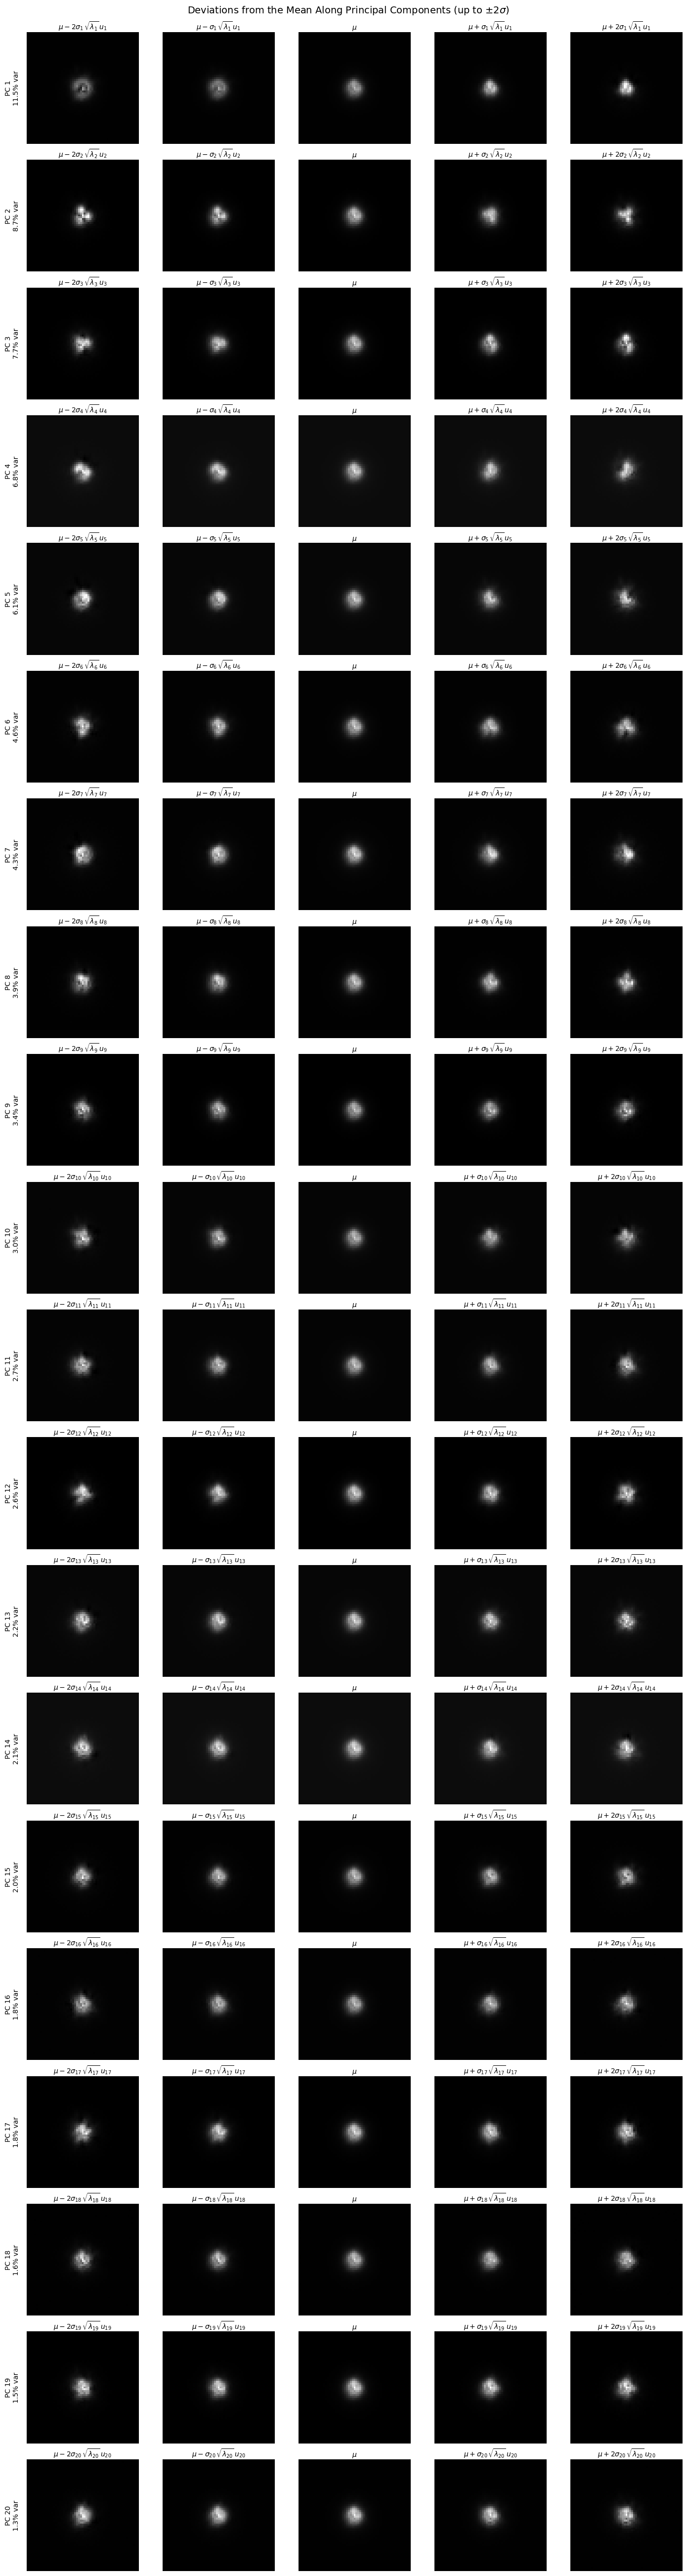

In [11]:
# Calculate deviations from the Mean PSF along Principal Components
fig_rows = []
n_components = elbow_point

for k in range(n_components):

    # Magnitude to move along kth Principal Component
    sigma = np.sqrt(max(psf_eigvals[k], 0.0))  

    minus_img_2s = psf_mean - 2 * sigma * psf_pcomp[k,:,:]  # 2 standard deviations in the negative direction
    minus_img_1s = psf_mean - sigma * psf_pcomp[k,:,:]      # 1 standard deviation in the negative direction 
    mean_img  = psf_mean                                    # Mean PSF
    plus_img_1s  = psf_mean + sigma * psf_pcomp[k,:,:]      # 1 standard deviation in the positive direction 
    plus_img_2s  = psf_mean + 2 * sigma * psf_pcomp[k,:,:]  # 2 standard deviations in the positive direction 
        
    vmin = min(minus_img_2s.min(), minus_img_1s.min(), mean_img.min(), plus_img_1s.min(), plus_img_2s.min())
    vmax = max(minus_img_2s.max(), minus_img_1s.max(), mean_img.max(), plus_img_1s.max(), plus_img_2s.max())

    fig_rows.append((minus_img_2s, minus_img_1s, mean_img, plus_img_1s, plus_img_2s, vmin, vmax))

# Generate plots of deviations from the Mean PSSF along Principal Components
fig, axes = plt.subplots(n_components, 5, figsize=(14, 2.6 * n_components), constrained_layout=True)

if n_components == 1:
    axes = np.array([axes])  # ensure axes are 2D

for k, (minus_img_2s, minus_img_1s, mean_img, plus_img_1s, plus_img_2s, vmin, vmax) in enumerate(fig_rows):
    for j, (img, title) in enumerate([(minus_img_2s, r"$\mu - 2\sigma_{%d}\,\sqrt{\lambda_{%d}}\,u_{%d}$" % (k+1, k+1, k+1)),
                                      (minus_img_1s, r"$\mu - \sigma_{%d}\,\sqrt{\lambda_{%d}}\,u_{%d}$" % (k+1, k+1, k+1)),
                                      (mean_img,  r"$\mu$"),
                                      (plus_img_1s,  r"$\mu + \sigma_{%d}\,\sqrt{\lambda_{%d}}\,u_{%d}$" % (k+1, k+1, k+1)),
                                      (plus_img_2s,  r"$\mu + 2\sigma_{%d}\,\sqrt{\lambda_{%d}}\,u_{%d}$" % (k+1, k+1, k+1))]):
        ax = axes[k, j]
        im = ax.imshow(img[ps:-ps,ps:-ps], cmap='gray', origin='lower', vmin=vmin, vmax=vmax, interpolation='none')
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_title(title, fontsize=10, pad=4)

    # Add a row label on the left margin (component index and explained variance ratio)
    var_ratio = psf_pca_elbow.explained_variance_ratio_[k]
    axes[k, 0].set_ylabel(f"PC {k+1}\n{var_ratio*100:.1f}% var", rotation=90, fontsize=10, labelpad=10)

fig.suptitle(r"Deviations from the Mean Along Principal Components (up to $\pm 2\sigma$)", fontsize=14)
plt.show()

In [12]:
# Project PSFs onto space spanned by principal components 
psf_pcaproj = psf_pca_elbow.transform(psfs_flattened)
print('Dimensions - PSFs projected onto space spanned by Principal Components:', psf_pcaproj.shape)

# Reconstruct PSFs in PCA Basis
psf_reconstructions_flattened = psf_pcaproj@psf_pcomp_flattened
print('Dimensions - Flattened Reconstructed PSFs:', psf_reconstructions_flattened.shape)

# Reshape reconstructed PSFs
psf_reconstructions = psf_reconstructions_flattened.reshape(num_psfs, psf_size, psf_size) + psf_mean
print('Dimensions - Reconstructed PSFs:', psf_reconstructions.shape)

Dimensions - PSFs projected onto space spanned by Principal Components: (100, 20)
Dimensions - Flattened Reconstructed PSFs: (100, 9801)
Dimensions - Reconstructed PSFs: (100, 99, 99)


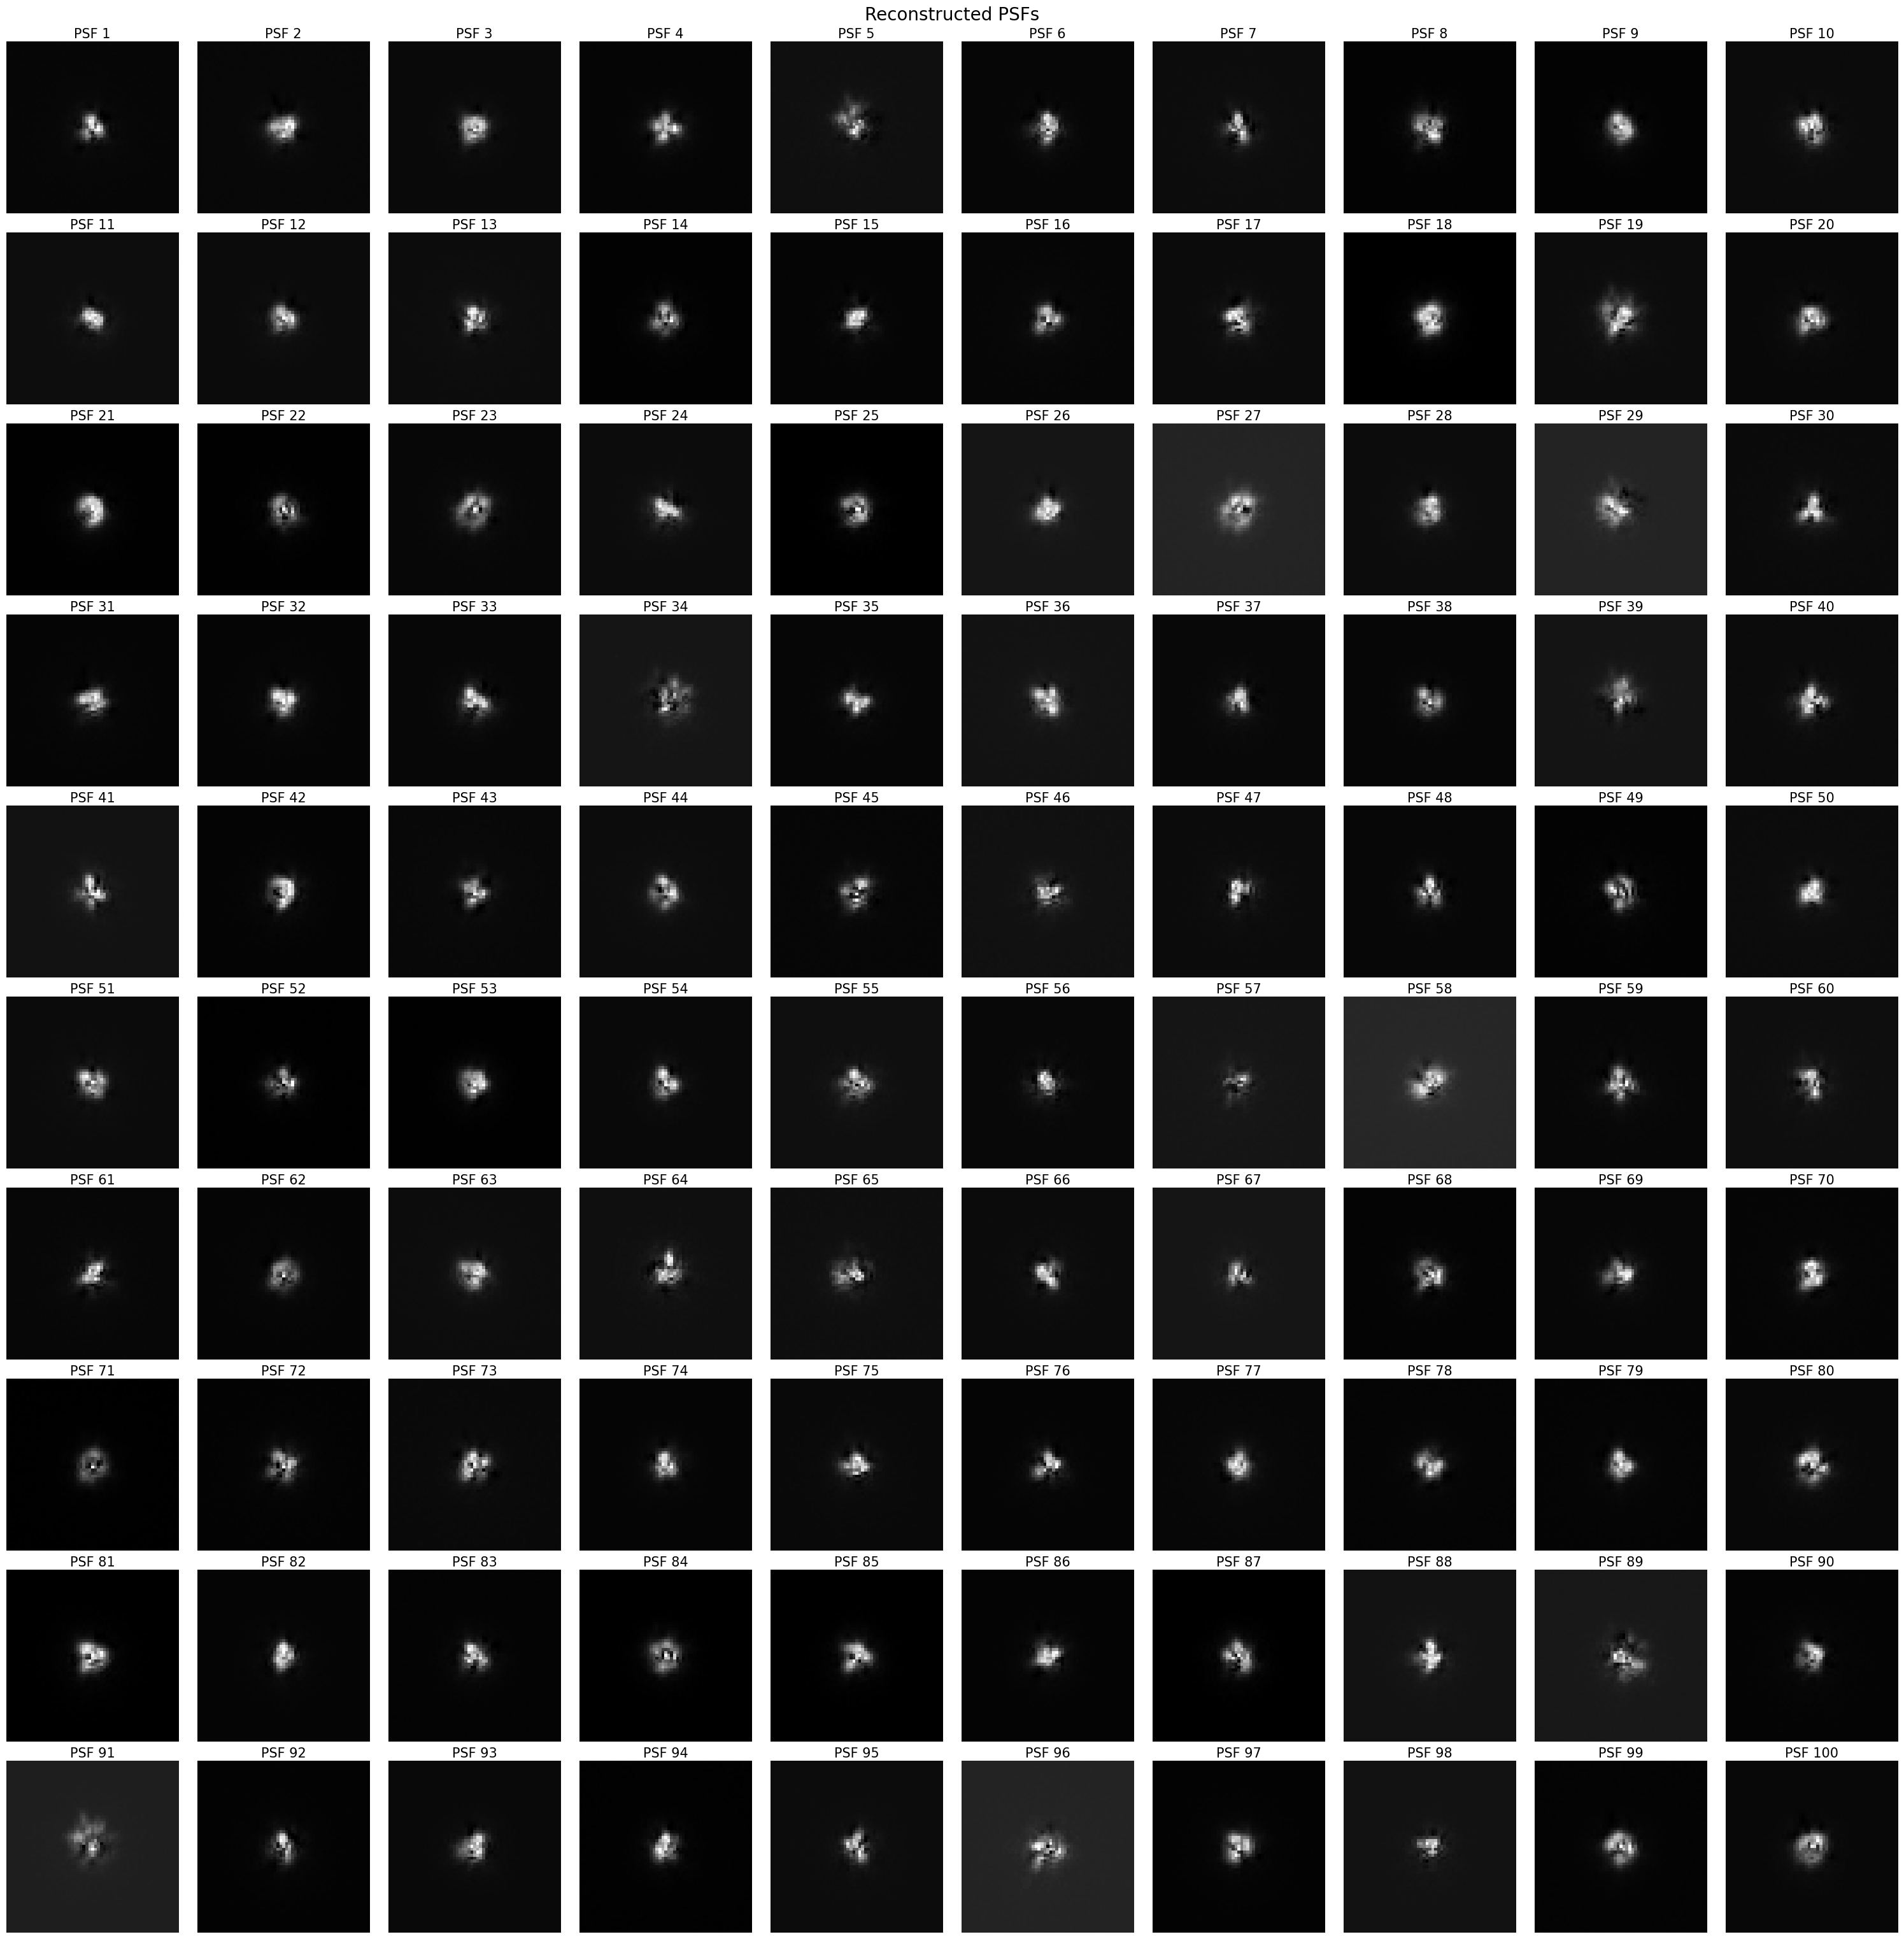

In [13]:
# Visualize Reconstructed PSFs
fig_reconstructed_psfs, axes_reconstructed_psfs = visualize_psfs(psf_reconstructions, ncols=10, title='Reconstructed PSFs', ps=ps)

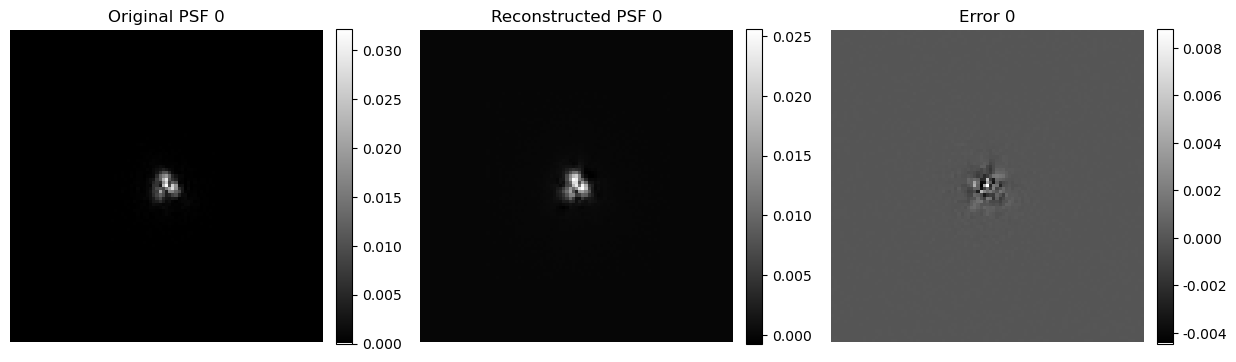

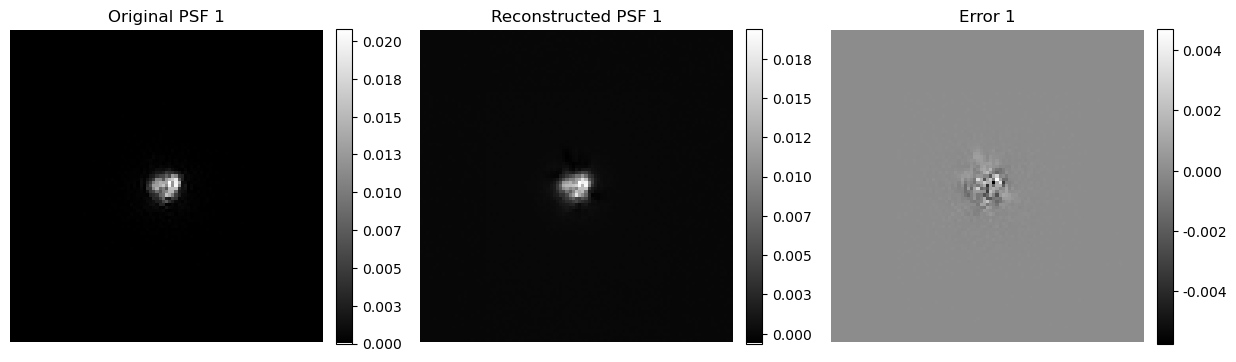

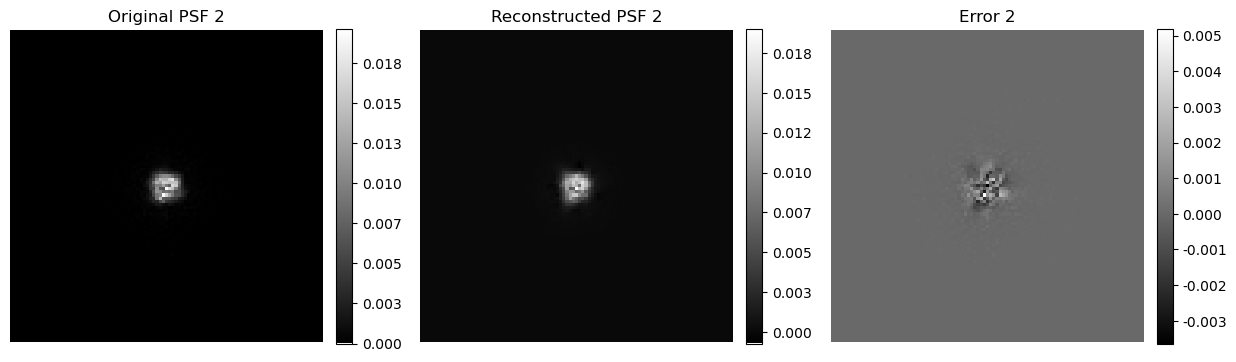

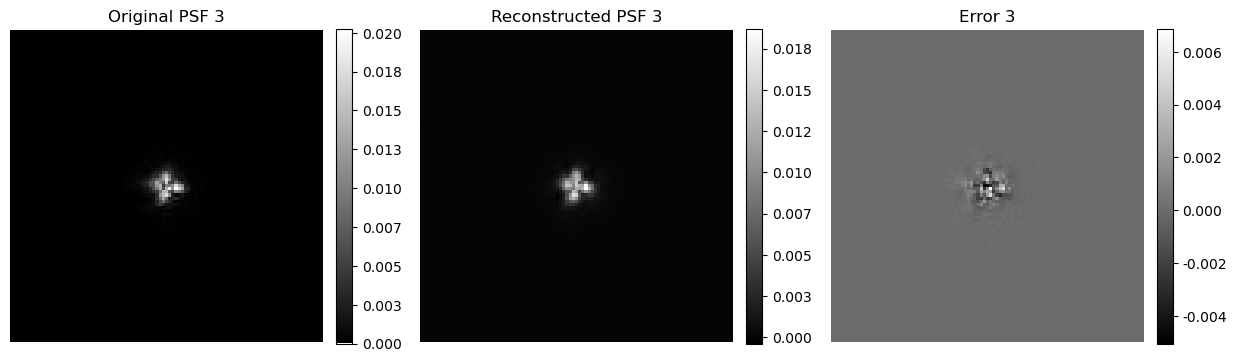

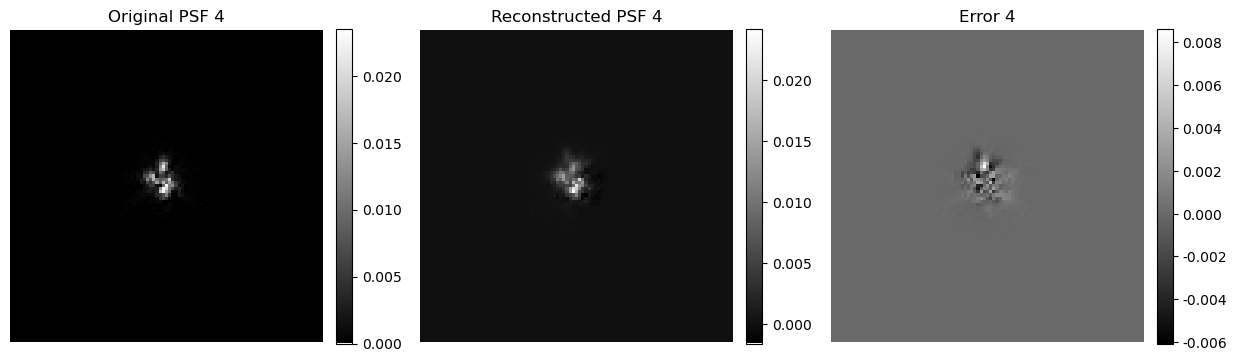

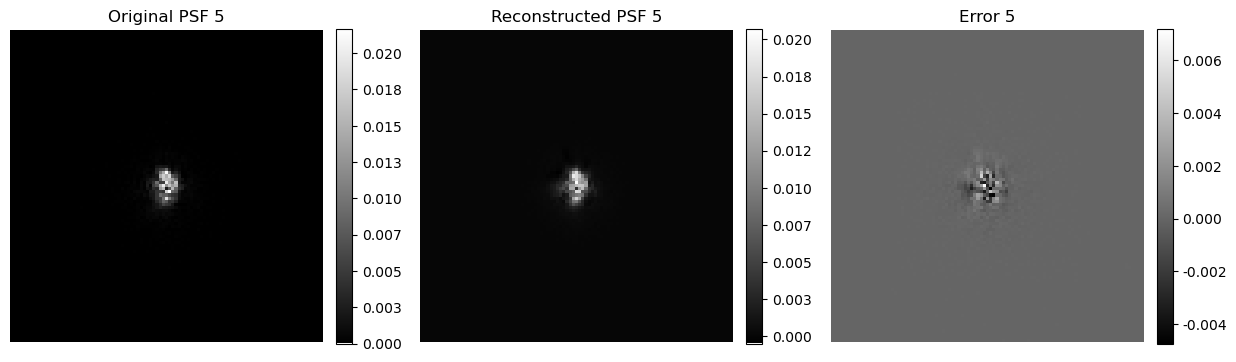

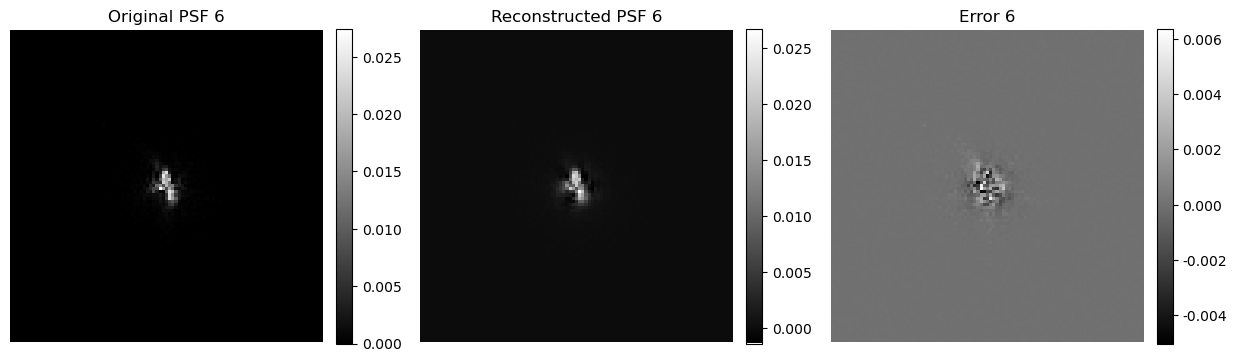

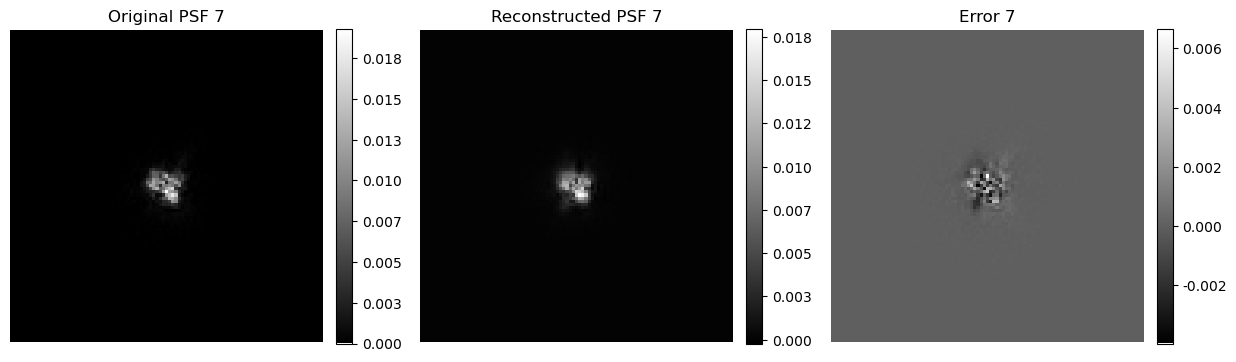

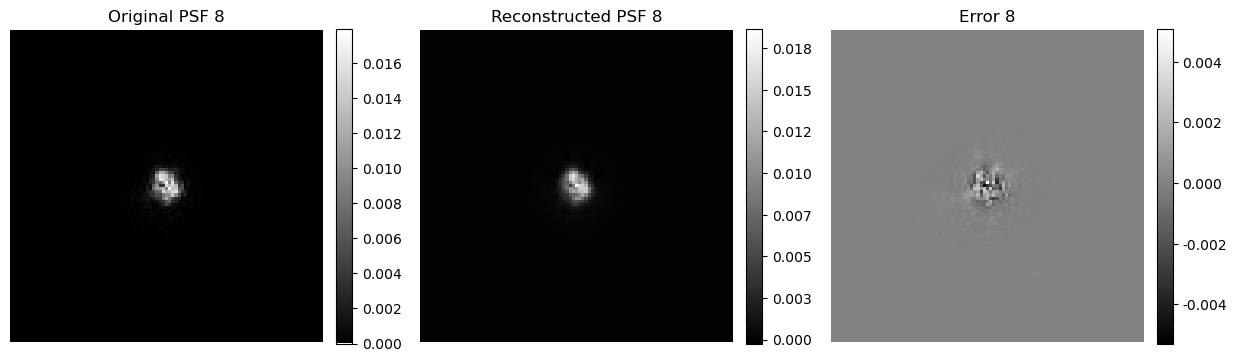

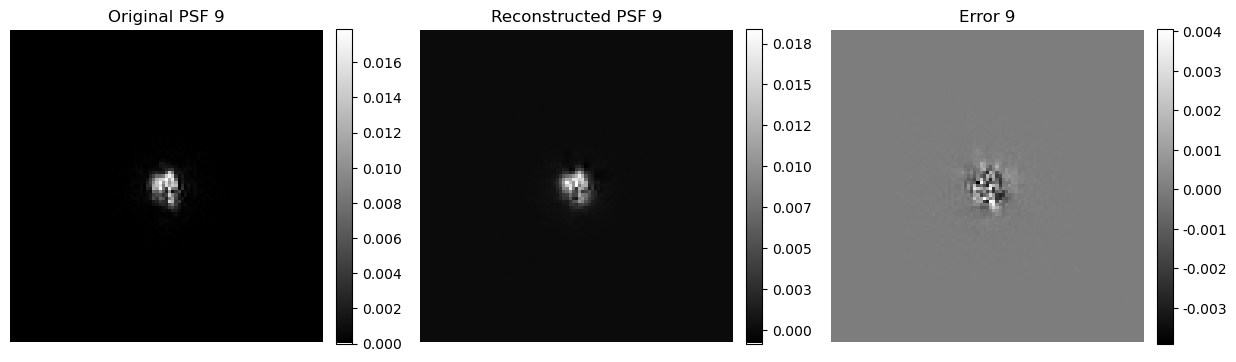

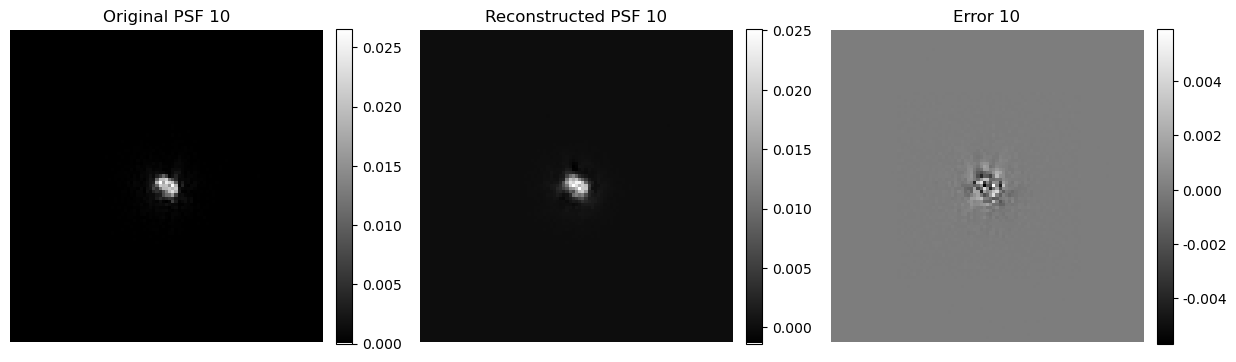

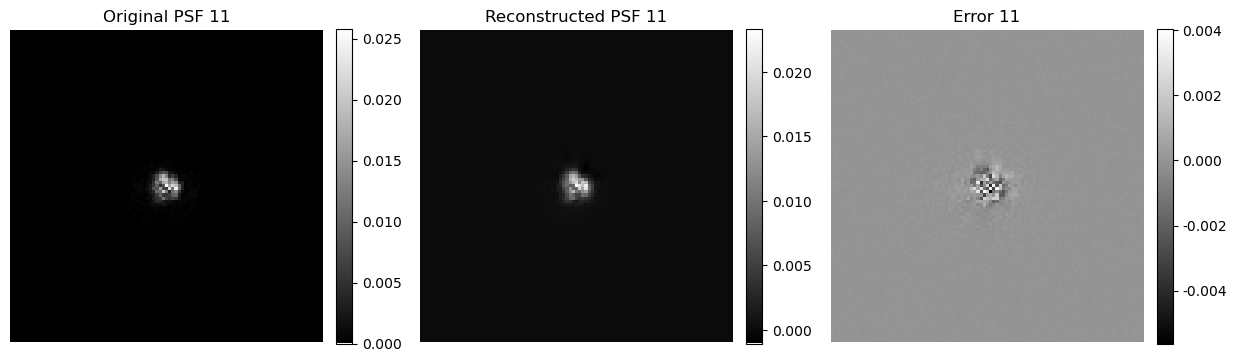

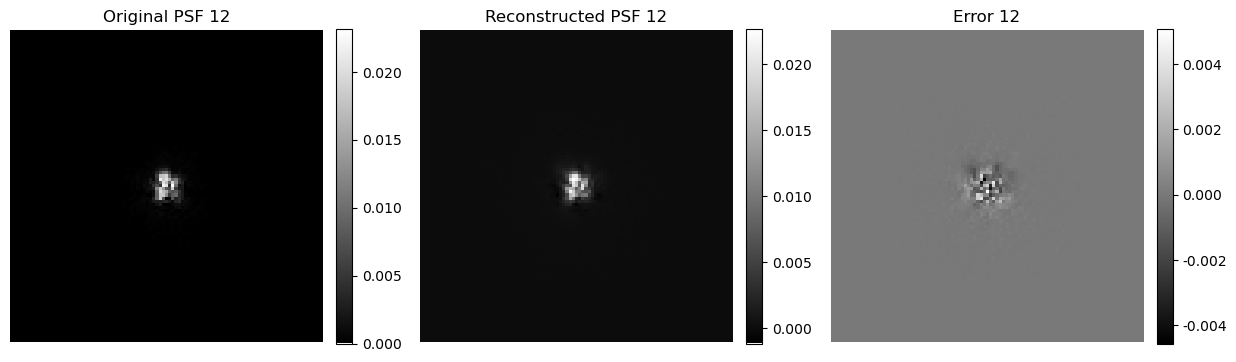

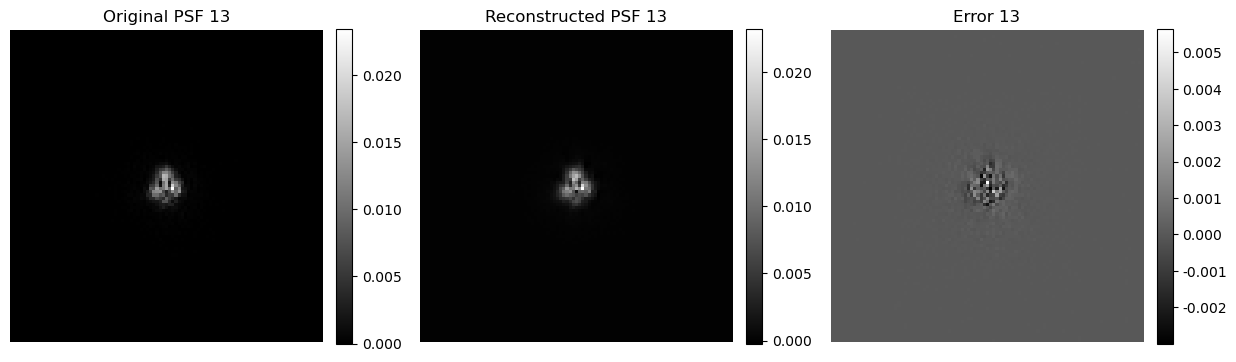

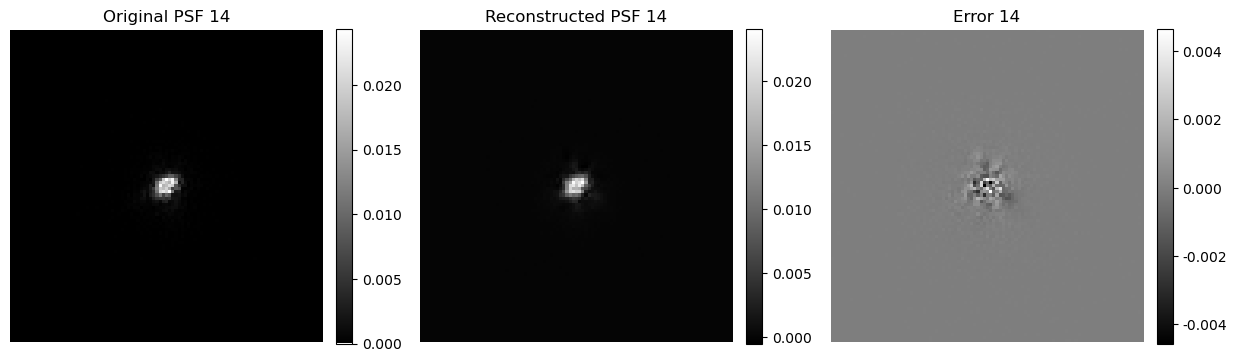

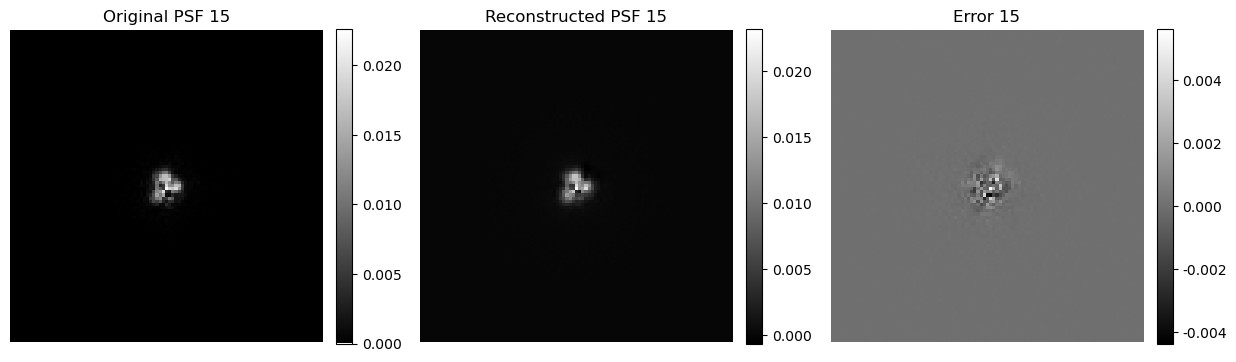

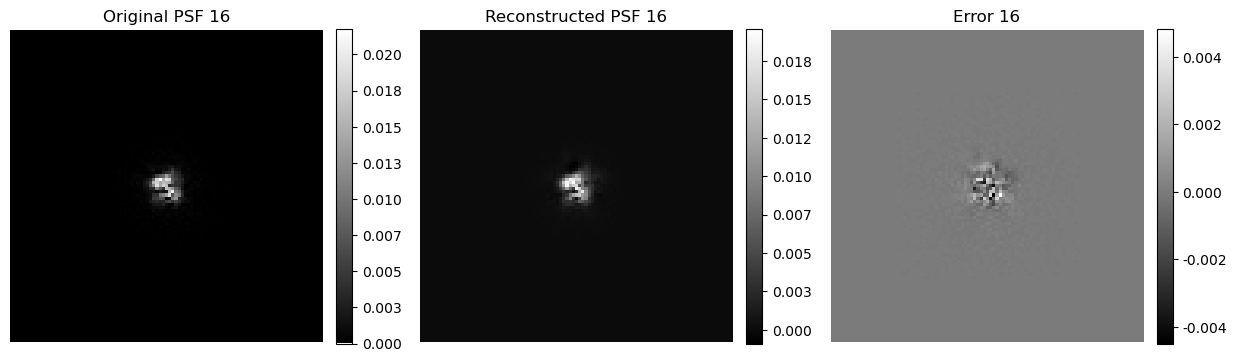

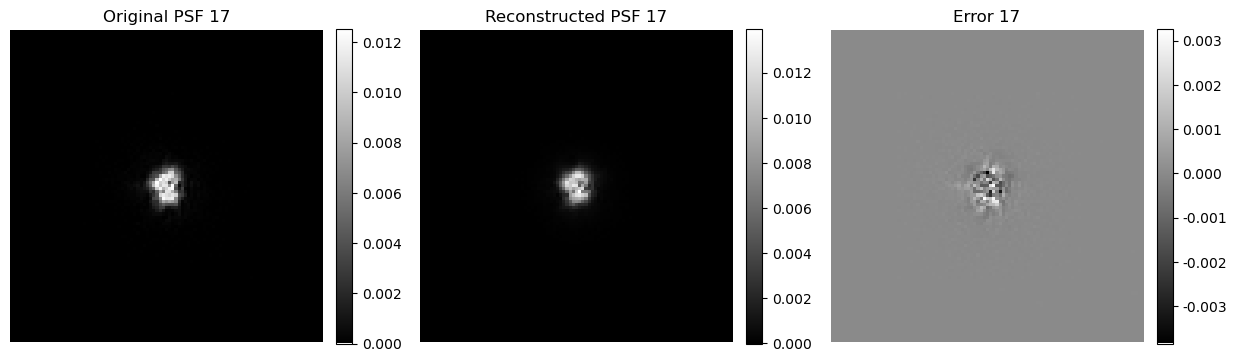

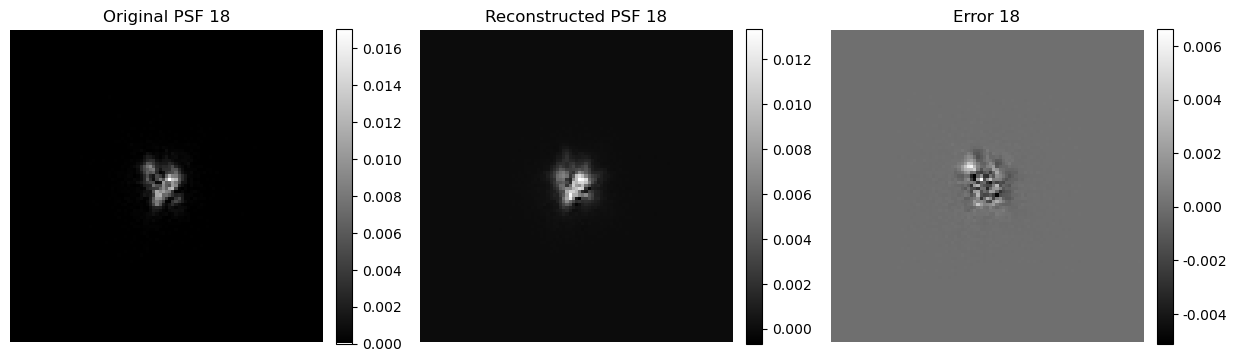

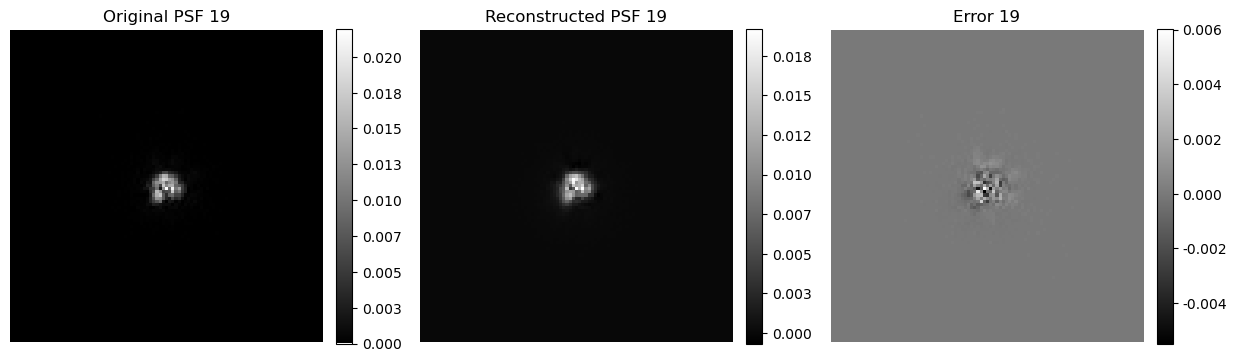

In [14]:
# Visualize and compare Original PSFs with Reconstructed PSFs
compare_psfs(psfs, psf_reconstructions, ps=0, n_show=20, 
             titles=['Original PSF','Reconstructed PSF','Error'], 
             cmap='gray', origin='lower', interpolation='none')

## Time Series Analysis of PSFs

In [15]:
# Create pandas dataframe of PCA Projections for each PSF
num_pc = 3
pcaproj = psf_pcaproj[:,:num_pc]  # Select projections onto first few selected PCs
col_names = [r"$\alpha_{%d}$" % (i+1) for i in range(pcaproj.shape[1])]  # column names
index_names = [f"PSF_proj_{i+1}" for i in range(pcaproj.shape[0])]       # observation names

pcaproj_df = pd.DataFrame(pcaproj, columns=col_names, index=index_names)

# Show first few rows
pcaproj_df.head(10)

,$\alpha_{1}$,$\alpha_{2}$,$\alpha_{3}$
PSF_proj_1,0.028373,-0.021585,0.007408
PSF_proj_2,0.002191,0.013223,-0.015796
PSF_proj_3,0.001572,-0.000367,-0.011126
PSF_proj_4,-0.005404,-0.011626,-0.006599
PSF_proj_5,-0.006151,0.007541,-0.015520
PSF_proj_6,0.006332,0.000424,0.016781
PSF_proj_7,0.019391,0.012766,0.042752
PSF_proj_8,-0.014579,0.017746,0.003401
PSF_proj_9,0.002072,-0.008441,0.008474
PSF_proj_10,-0.002071,0.014687,0.007879


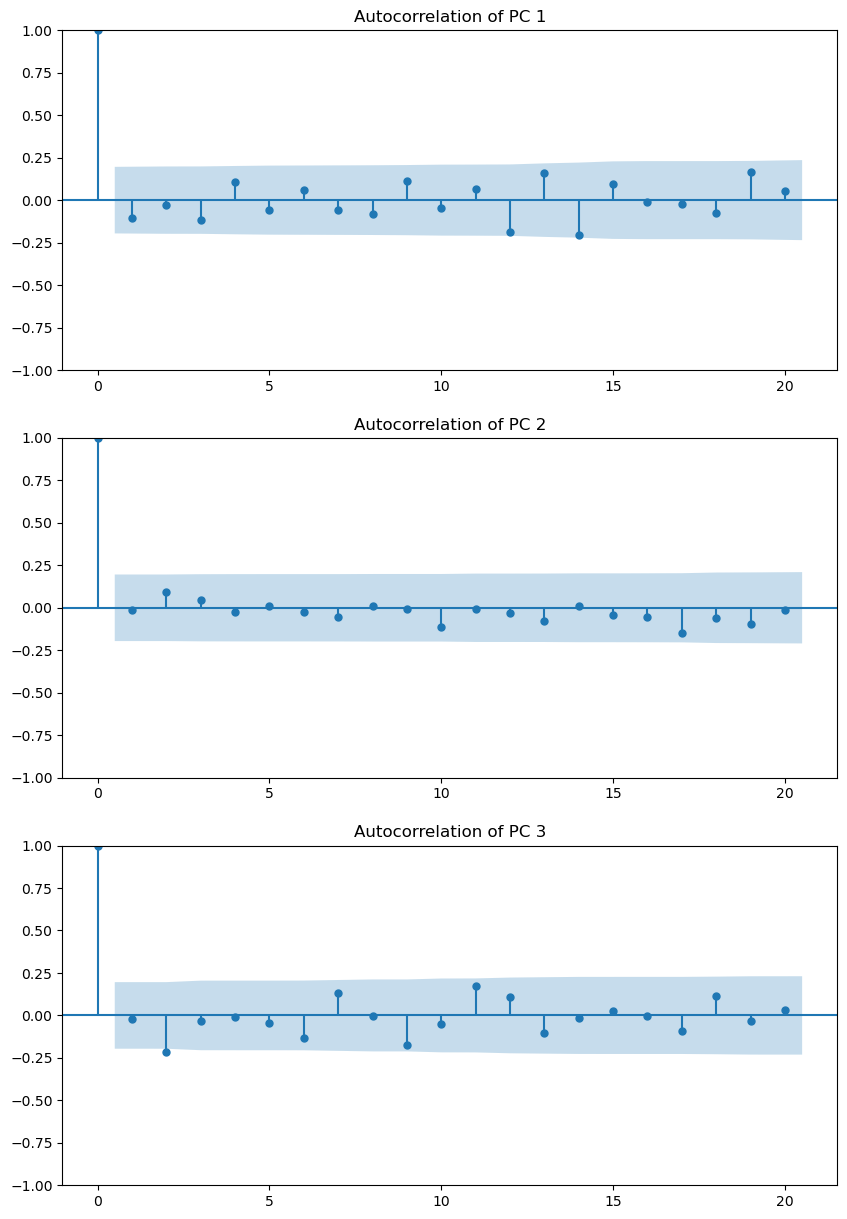

In [16]:
# Plot auto-correlation function
alpha = 0.05  # Significance level
lags = 20     # Time lags

fig_acf, axes_acf = plt.subplots(3,1,figsize=(10, 15))
plot_acf(pcaproj[:,0], lags=lags, alpha=alpha, title='Autocorrelation of PC 1', ax=axes_acf[0])
plot_acf(pcaproj[:,1], lags=lags, alpha=alpha, title='Autocorrelation of PC 2', ax=axes_acf[1])
plot_acf(pcaproj[:,2], lags=lags, alpha=alpha, title='Autocorrelation of PC 3', ax=axes_acf[2])
plt.show()

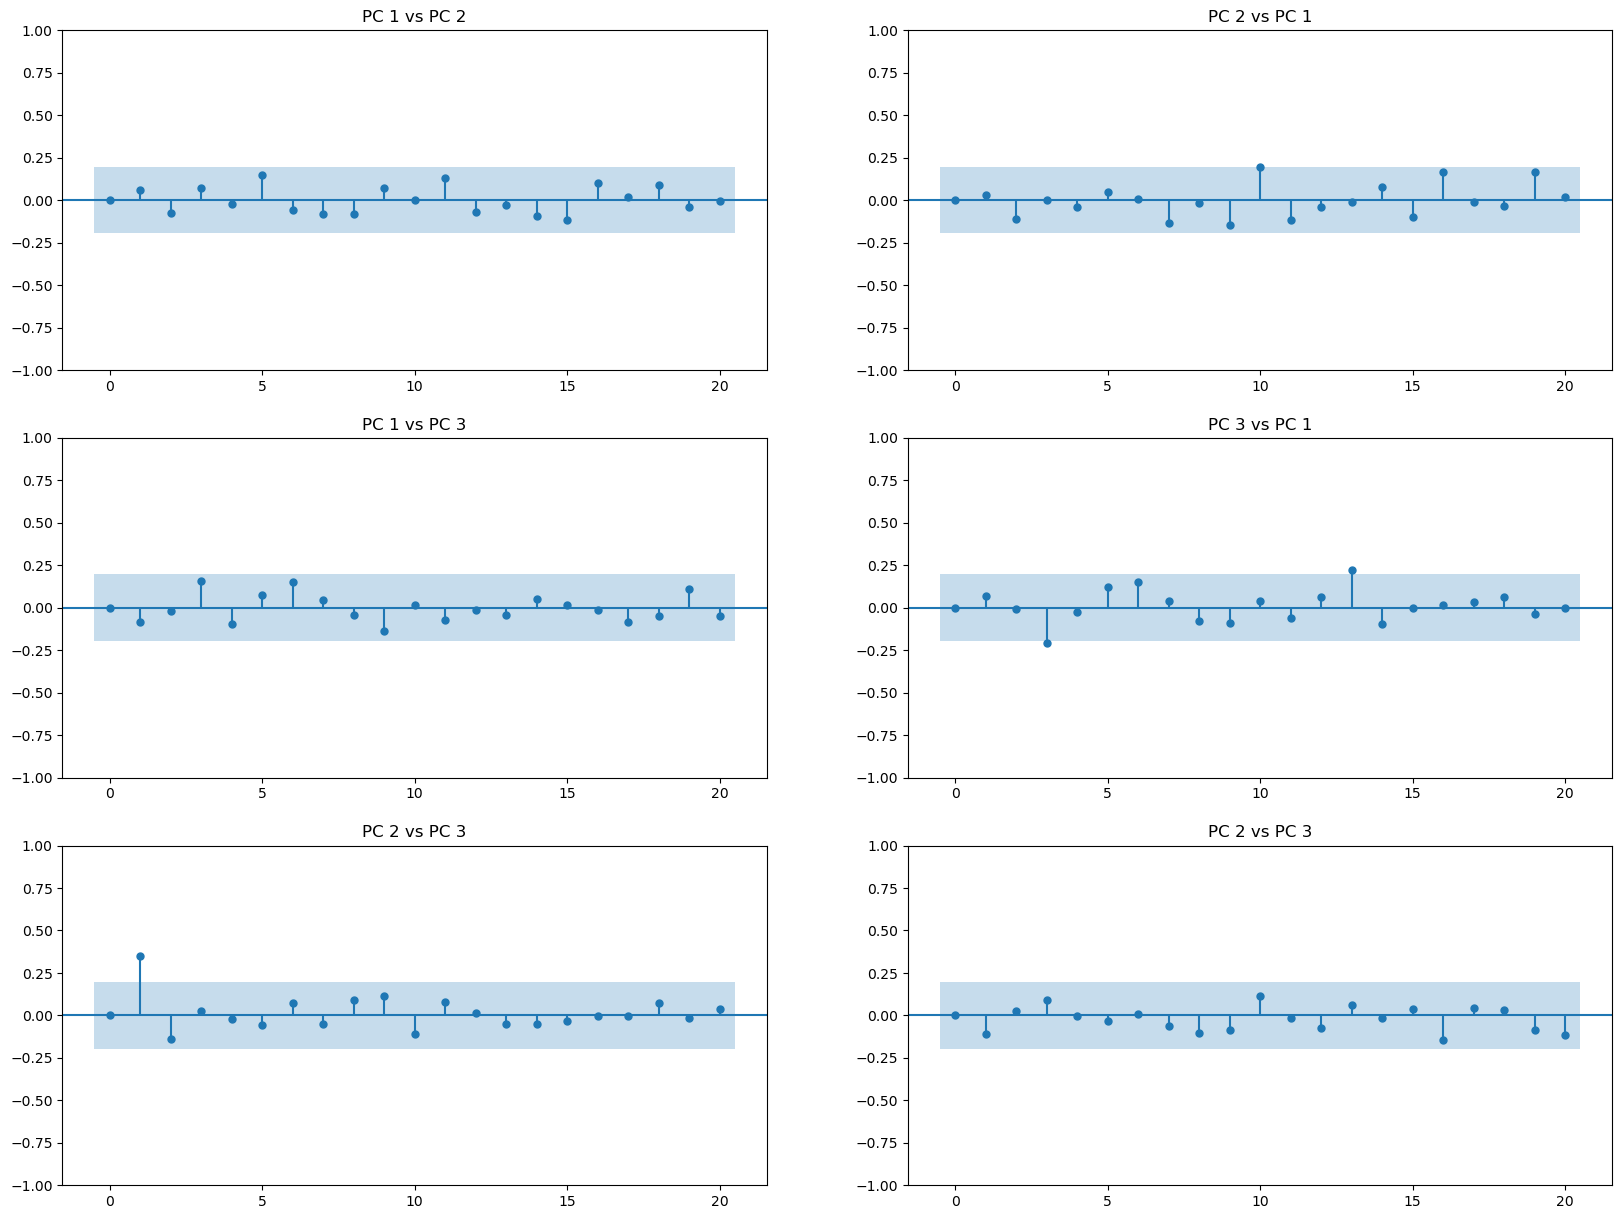

In [17]:
# Plot cross-correlation functions
alpha = 0.05  # Significance level
lags = 20     # Time lags

fig_ccf, axes_ccf = plt.subplots(3,2,figsize=(20, 15))
plot_ccf(pcaproj[:,0], pcaproj[:,1], lags=lags, alpha=alpha, title='PC 1 vs PC 2', ax=axes_ccf[0,0])
plot_ccf(pcaproj[:,1], pcaproj[:,0], lags=lags, alpha=alpha, title='PC 2 vs PC 1', ax=axes_ccf[0,1])
plot_ccf(pcaproj[:,0], pcaproj[:,2], lags=lags, alpha=alpha, title='PC 1 vs PC 3', ax=axes_ccf[1,0])
plot_ccf(pcaproj[:,2], pcaproj[:,0], lags=lags, alpha=alpha, title='PC 3 vs PC 1', ax=axes_ccf[1,1])
plot_ccf(pcaproj[:,1], pcaproj[:,2], lags=lags, alpha=alpha, title='PC 2 vs PC 3', ax=axes_ccf[2,0])
plot_ccf(pcaproj[:,2], pcaproj[:,1], lags=lags, alpha=alpha, title='PC 2 vs PC 3', ax=axes_ccf[2,1])
plt.show()

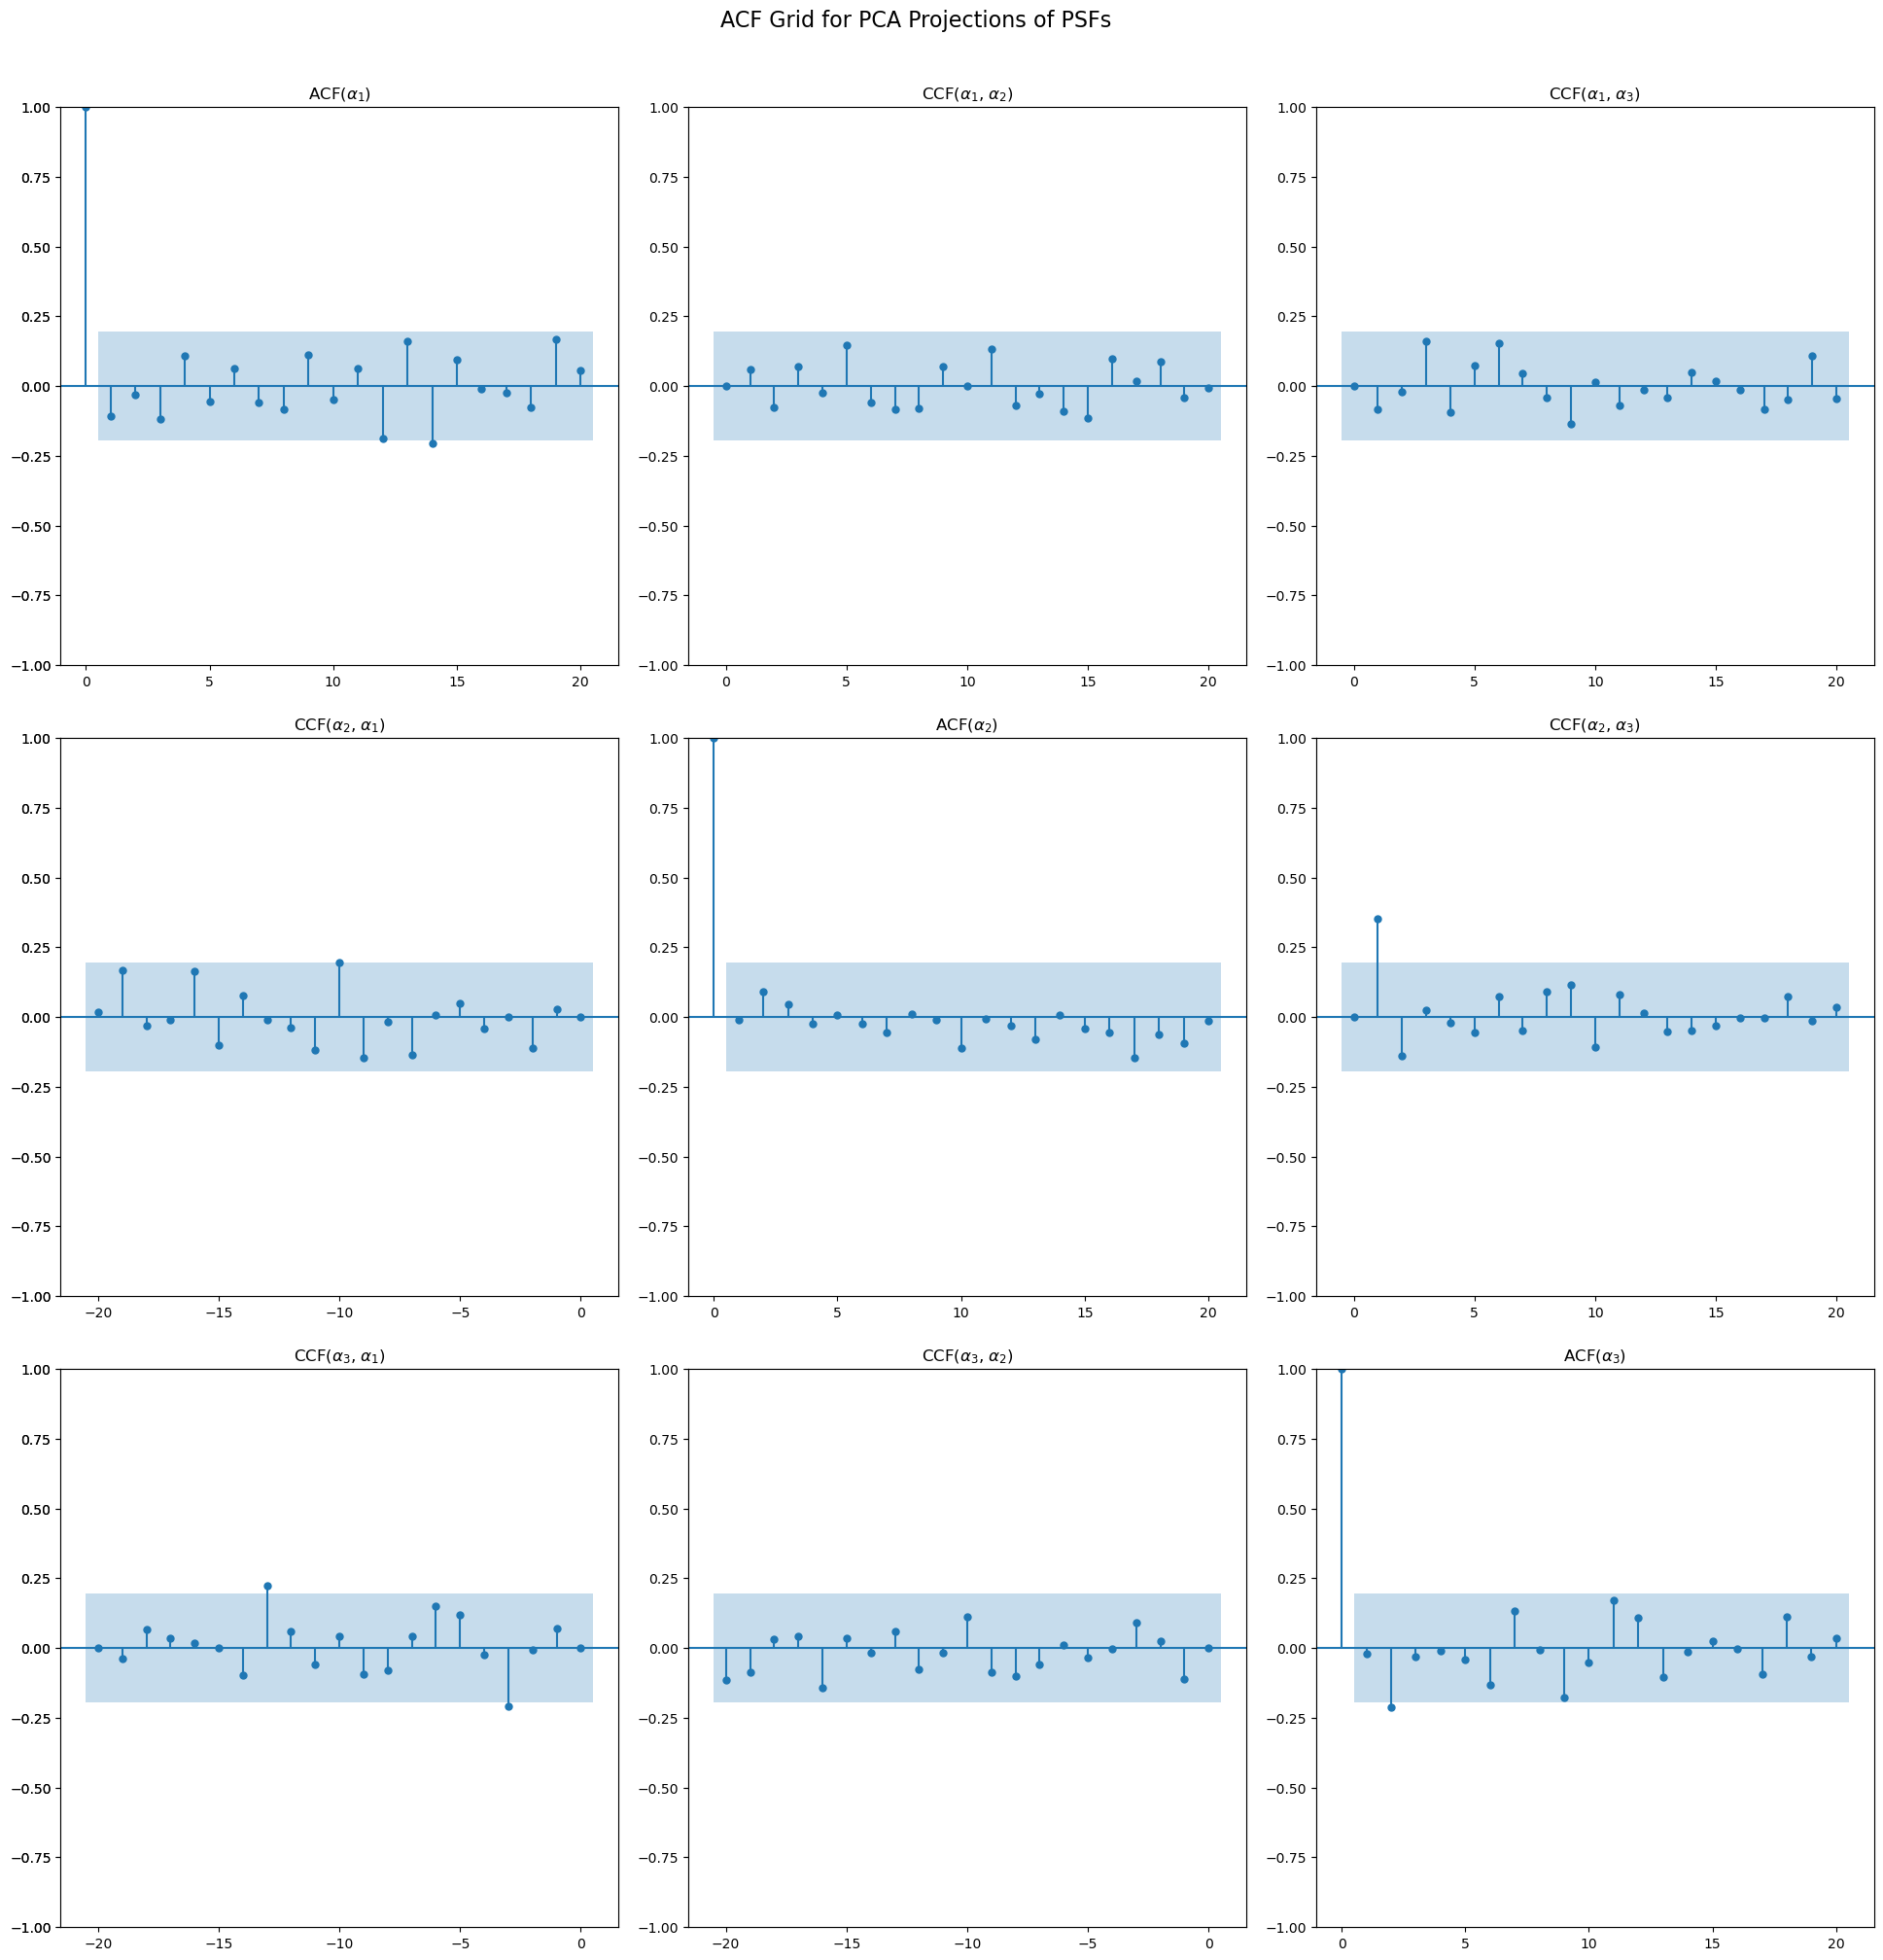

In [18]:
# Plot auto/cross-correlation (ACCF) grid of the PCA Projections
alpha = 0.05  # Significance level
lags = 20     # Time lags

fig_accf, axes_accf = plt.subplots(num_pc, num_pc, figsize=(20, 20), sharex=True, sharey=True)
plot_accf_grid(pcaproj_df, lags=lags, alpha=alpha, fig=fig_accf)
#plot_accf_grid(np.abs(projs), lags=20, alpha=0.05, fig=fig) # absolute value
#plot_accf_grid(projs**2, lags=20, alpha=0.05, fig=fig) # squared

# Set limits of x and y axis for display purposes
for i in range(num_pc):
    for j in range(num_pc):
        
        # Limits of x axis
        if i <= j:
            axes_accf[i,j].set_xlim(0, lags)
            axes_accf[i,j].set_xticks([])

        else:
            axes_accf[i,j].set_xlim(-lags, 0)
            axes_accf[i,j].set_xticks([])
    
    # Limits of y axis
    axes_accf[i,j].set_ylim(-1, 1)
    axes_accf[i,j].set_yticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])

plt.suptitle('ACF Grid for PCA Projections of PSFs', fontsize=16, y=1.01)
plt.tight_layout() 
plt.show()

## Perform Multivariate Ljung-Box test

We consider the multivariate time series data obtained by projecting each PSF onto its first few principal components. We test whether this time series data is pure white noise via the Multivariate Ljung-Box test. To do so, we follow the following steps:

**Step 1**: Check whether the time series formed by the projections of each PSF onto its first few principal compinents is stationary. We use the Augmented Dickey-Fuller (ADF) test to check for stationarity.

**Step 2**: Fit a VAR (Vector Autoregression) model with a lag of 0. Doing so essentially means that we treat the original time series as the residuals of a model with no parameters.

**Step 3**: Perform the multivariate Ljung-Box test on the series formed by fitting the VAR model.

In [19]:
# Check stationarity using the ADF test (at the 5% significance level)
for column in pcaproj_df.columns:
    result = adfuller(pcaproj_df[column])
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value for {column}: {result[1]}')
    if result[1] <= 0.05:
        print(f"  --> {column} is stationary\n")
    else:
        print(f"  --> {column} is non-stationary (needs more differencing)\n")

ADF Statistic for $\alpha_{1}$: -11.028885401400695
p-value for $\alpha_{1}$: 5.734748488925038e-20
  --> $\alpha_{1}$ is stationary

ADF Statistic for $\alpha_{2}$: -10.06365159668069
p-value for $\alpha_{2}$: 1.3134542350713031e-17
  --> $\alpha_{2}$ is stationary

ADF Statistic for $\alpha_{3}$: -8.675337129463843
p-value for $\alpha_{3}$: 4.431967591747982e-14
  --> $\alpha_{3}$ is stationary



In [20]:
# Fit a VAR model with zero lag in order to treat the data as the residuals of a model with no parameters
var_model = VAR(pcaproj)  # first few PCs only # VAR(psf_pcaproj)  # All 20 PCs

var_pcaproj = var_model.fit(maxlags=0)

In [21]:
# Perform the multivariate Ljung-Box test on the series obtained after fitting the VAR model to the data
whiteness_test_results = var_pcaproj.test_whiteness(nlags=lags, signif=0.05)
whiteness_test_results.summary()

Test statistic,Critical value,p-value,df
142.0,212.3,0.983,180
